***
# ***Predicting the Boiling and Melting Point - COMS5024A***
***

### **Table of Contents**
- [Introduction](#1)
  * [Context](#5)
  * [Python Installations](#5)
- [Imports](#7)
  * [Library Imports](#8)
  * [Dataset](#9)
- [Exploretory Data Analysis](#10)
  * [Data Overview](#11)
  * [Visualizations](#12)
    * [Univariate Analysis](#13)
    * [Bivariate Analysis](#14)
    * [Multivariate Analysis](#15)
- [Data Pre-processing](#19)
  * [Feature Engineering](#20)
  * [Scaling The Data](#20)
- [Modelling](#25)
  * [Model Evaluation](#26)
  * [Hyperparameter Tuning](#26)
      * [Evaluation of Tuned Models](#26)
- [Discussion](#26)
    * [Model Comparison](#30)
      * [Before Hyperparamter Tuning](#31)
      * [After Hyperparamter Tuning](#32)
      * [(Potential) Challenges and Limitations](#33)


***
# ***Introduction***
***

## ***Context***

The objective in this notebook was to use RDKit to create a new dataset containing the atomic weight and the number of aromatic rings of the hydrocarbons. Then, using the new dataset, I use the MLPRegressor, a type of artificial neural network-based regression algorithm to predict the boiling and melting points of the hydrocarbons

## ***Python Installations***

In [1]:
%pip install --upgrade rdkit    # installing RDKit

***
# ***Imports***
***

## ***Library Imports***

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

## ***Dataset***

In [3]:
df = pd.read_csv("/content/hydrocarbons.csv")

***
# ***Exploratory Data Analysis***
***

## ***Data Overview***

In [4]:
df.info()   # basic information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Class of hydrocarbon  194 non-null    object 
 1   IUPAC name            194 non-null    object 
 2   Melting point         188 non-null    float64
 3   Boiling point         190 non-null    float64
 4   Density               189 non-null    object 
 5   Flash point           77 non-null     object 
 6   Autoignition temp     63 non-null     object 
 7   pubchem_id            194 non-null    int64  
 8   smiles                194 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 13.8+ KB


In [5]:
df.head() # first five rows of our data

,Class of hydrocarbon,IUPAC name,Melting point,Boiling point,Density,Flash point,Autoignition temp,pubchem_id,smiles
0,Trimetylalkane,"2,2,4-Trimethylpentane",-107.0,99.0,0.69,NaN,396,10907,CC(C)CC(C)(C)C
1,Triaromatics,Phenanthrene,99.0,338.0,1.18,171,>450,995,C1=CC=C2C(=C1)C=CC3=CC=CC=C32
2,Triaromatics,Anthracene,216.0,341.0,1.2825,NaN,NaN,8418,C1=CC=C2C=C3C=CC=CC3=CC2=C1
3,Triaromatics,1-methylanthracene,86.0,342.0,1.04799,NaN,NaN,11884,CC1=CC=CC2=CC3=CC=CC=C3C=C12
4,Triaromatics,2-methylanthracene,209.0,340.0,1.8,NaN,NaN,11936,CC1=CC2=CC3=CC=CC=C3C=C2C=C1


In [6]:
df.tail()   # last five rows of our data

,Class of hydrocarbon,IUPAC name,Melting point,Boiling point,Density,Flash point,Autoignition temp,pubchem_id,smiles
189,1-alkene,1-hexadecene,4.0,285.0,0.781,NaN,NaN,12395,CCCCCCCCCCCCCCC=C
190,1-alkene,1-heptadecene,11.0,301.0,0.785,NaN,NaN,23217,CCCCCCCCCCCCCCCC=C
191,1-alkene,1-octadecene,18.0,316.0,0.789,NaN,NaN,8217,CCCCCCCCCCCCCCCCC=C
192,1-alkene,1-nonadecene,23.0,331.0,0.78925,NaN,NaN,29075,CCCCCCCCCCCCCCCCCC=C
193,1-alkene,1-docosene,38.0,367.0,0.79425,NaN,NaN,74138,CCCCCCCCCCCCCCCCCCCCC=C


In [7]:
df.describe().transpose()   # basic stats of our data

,count,mean,std,min,25%,50%,75%,max
Melting point,188.0,-30.558511,81.925437,-188.0,-95.0,-27.5,15.25,256.0
Boiling point,190.0,208.631579,139.303563,-162.0,112.0,205.5,298.00,625.0
pubchem_id,194.0,55755.943299,331051.792210,241.0,8967.5,12404.0,19389.25,4526742.0


In [8]:
# checking for missing values
missing_values  = df.isna().sum()
print(f'The number of missing values in each column is: \n {missing_values}.')

The number of missing values in each column is: 
 Class of hydrocarbon      0
IUPAC name                0
Melting point             6
Boiling point             4
Density                   5
Flash point             117
Autoignition temp       131
pubchem_id                0
smiles                    0
dtype: int64.


In [9]:
# checking for duplicates
print(f'The number of duplicated rows in this dataframe is: \n {df.duplicated().sum()}')

The number of duplicated rows in this dataframe is: 
 0


In [10]:
# storing the features in lists accodring to their data type.

categorical = [column for column in df.columns if df[column].dtype == object] # categorical features
discrete = [column for column in df.columns if df[column].dtype == int] # discrete features
continuous = [column for column in df.columns if df[column].dtype == float] # continuous features

print(f'categorical features : {categorical}')
print(f'discrete features : {discrete}')
print(f'continuous features : {continuous}')

categorical features : ['Class of hydrocarbon', 'IUPAC name', 'Density', 'Flash point', 'Autoignition temp', 'smiles']
discrete features : ['pubchem_id']
continuous features : ['Melting point', 'Boiling point']


From the above we can see that some features within the categorical list are continuous , such as 'Density', 'Flash point', 'Autoignition temp'. This is due to the fact that some entries are recorded as '>6.7' causing the column to not be identified as continuous. I convert these three columns to numerical columns, but values such as '>6.7' will be converted to NaN (missing values).

In [11]:
# coverting same columns to numericial
df[['Density', 'Flash point', 'Autoignition temp']] = df[['Density', 'Flash point', 'Autoignition temp']].apply(pd.to_numeric, errors='coerce')

In [12]:
# revisiting the column types

# storing the features in lists accodring to their data type.
categorical = [column for column in df.columns if df[column].dtype == object] # categorical features
discrete = [column for column in df.columns if df[column].dtype == int] # discrete features
continuous = [column for column in df.columns if df[column].dtype == float] # continuous features

print(f'categorical features : {categorical}')
print(f'discrete features : {discrete}')
print(f'continuous features : {continuous}')

categorical features : ['Class of hydrocarbon', 'IUPAC name', 'smiles']
discrete features : ['pubchem_id']
continuous features : ['Melting point', 'Boiling point', 'Density', 'Flash point', 'Autoignition temp']


The three columns 'Density', 'Flash point', 'Autoignition temp' have been sucessfully converted to numerical columns.

In [13]:
# revisiting missing values

missing_values_revisit  = df.isna().sum()
print(f'The number of missing values in each column is: \n {missing_values_revisit}.')

The number of missing values in each column is: 
 Class of hydrocarbon      0
IUPAC name                0
Melting point             6
Boiling point             4
Density                  12
Flash point             124
Autoignition temp       132
pubchem_id                0
smiles                    0
dtype: int64.


1) For Density the missing values increased by 7.

2) For Flash Point the missing values increased by 7.

3) For Autoignition temp the missing values increased by 1.

In [14]:
print(f'There are {len(categorical)} categorical features.')
print(f'There are {len(discrete)} discrete features.')
print(f'There are {len(continuous)} continuous features.')

There are 3 categorical features.
There are 1 discrete features.
There are 5 continuous features.


## ***Visualizations***

### ***Univariate Analysis***

In [15]:
# creating a function to plot the distribution of continuous features

def histogram(continuous_features_list, data):
    for column in continuous_features_list:   # looping through the continuous features list
      sns.histplot(data=data, x=df[column], kde=True) # histogram plot
      plt.title(f'Distribution of {column}')
      plt.show()
      print()

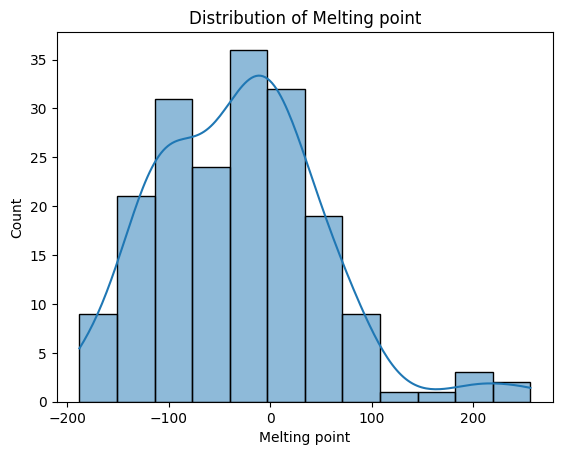

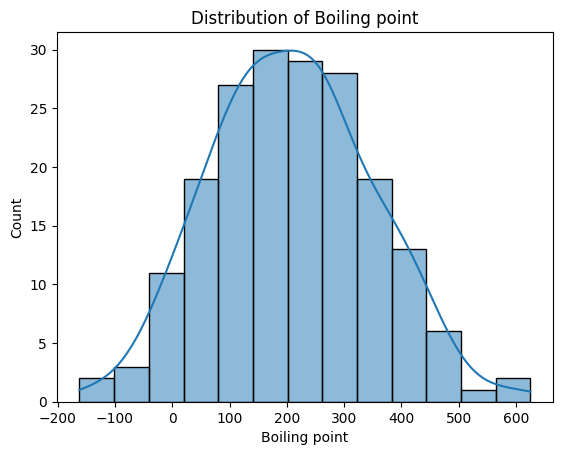

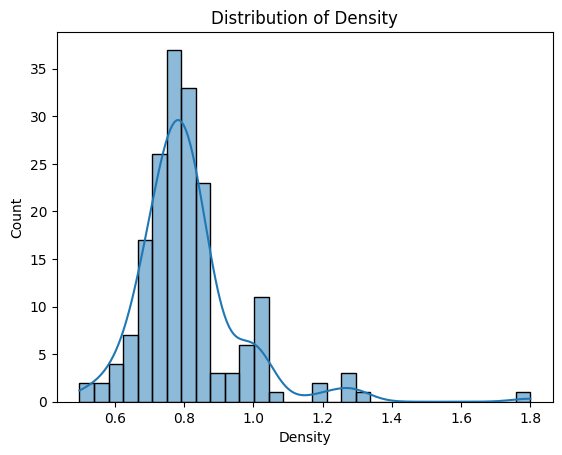

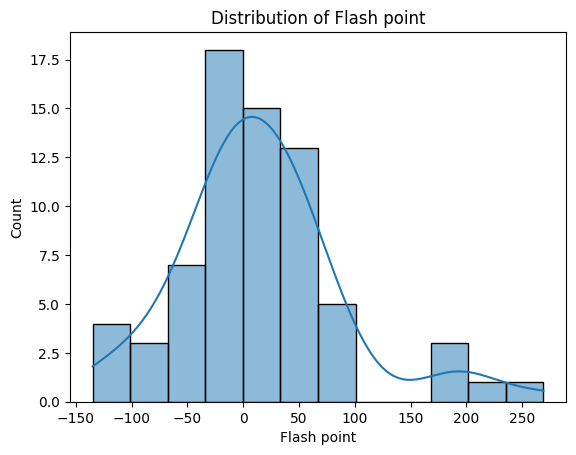

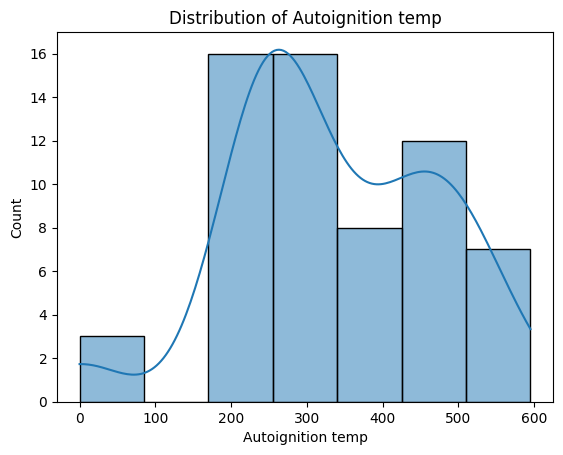

In [16]:
histogram(continuous, df)

It is clearly evident that there are missing values in the following columns: 'Density', 'Flash point', 'Autoignition temp'. This is because of two reasons:

i) The dataset already had ssing values in those columns

ii) The conversion of the columns to numercial columns caused non-numerical entries like the ones mentioned eariler to be NaN.

In [17]:
# intepretating the categorical features

for column in categorical:
  print(f'There are {df[column].nunique()} unique categories in {column}')

There are 19 unique categories in Class of hydrocarbon
There are 194 unique categories in IUPAC name
There are 192 unique categories in smiles


### ***Bivariate Analysis***

In [18]:
# creating a function for feature to feature plots for continous features
def scatter(continuous_features_list, data, hue_feature):
    for column in continuous_features_list: # looping through the continuous features list
      if column != 'Boiling point':    # I chose to compare the Boiling point to the rest of the continuous features
        plt.figure(figsize=(10,10))
        sns.scatterplot(x=data['Boiling point'], y=data[column], hue=data[hue_feature]) # scatterplot
        plt.title(f'Boiling point VS {column}')
        plt.xlabel(f'Boiling point')
        plt.ylabel(f'{column}')
        plt.show()
        print()

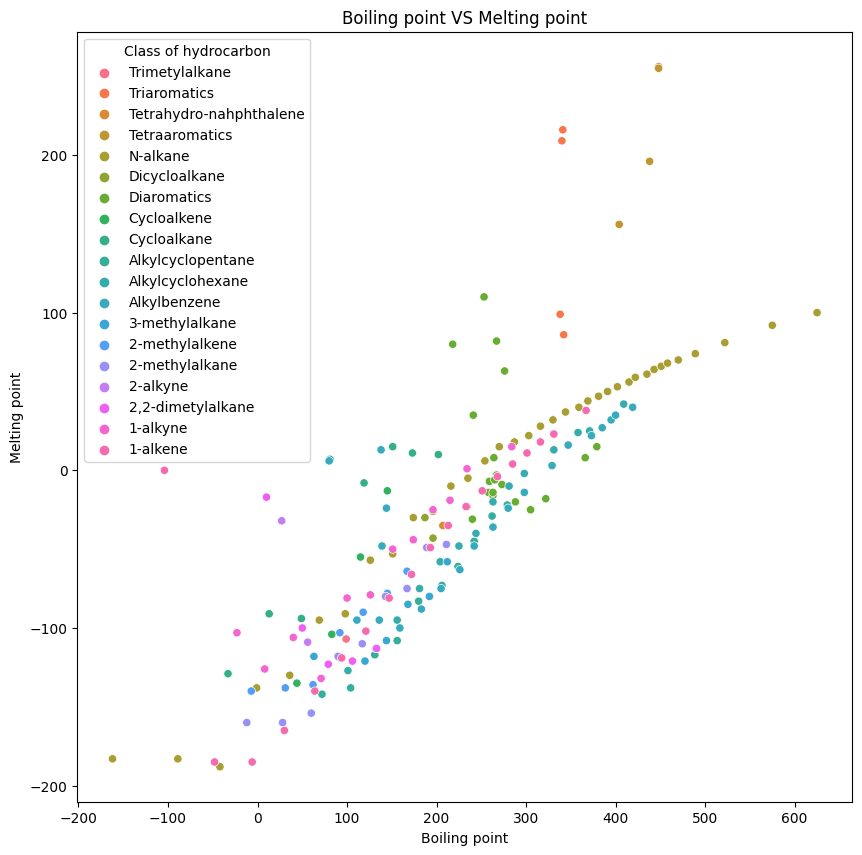

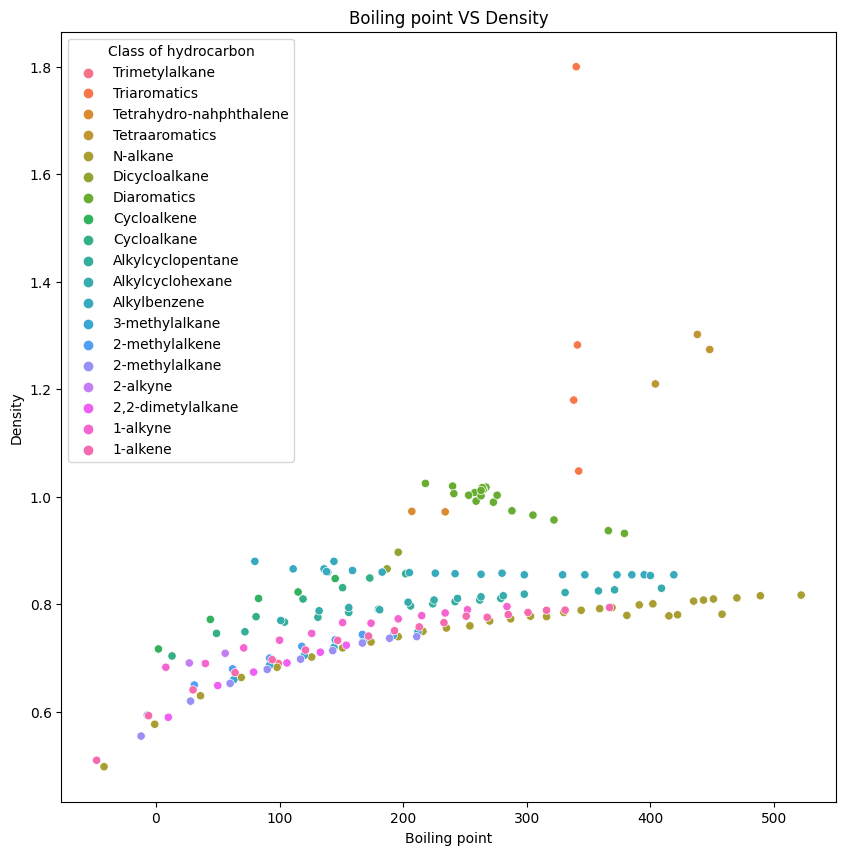

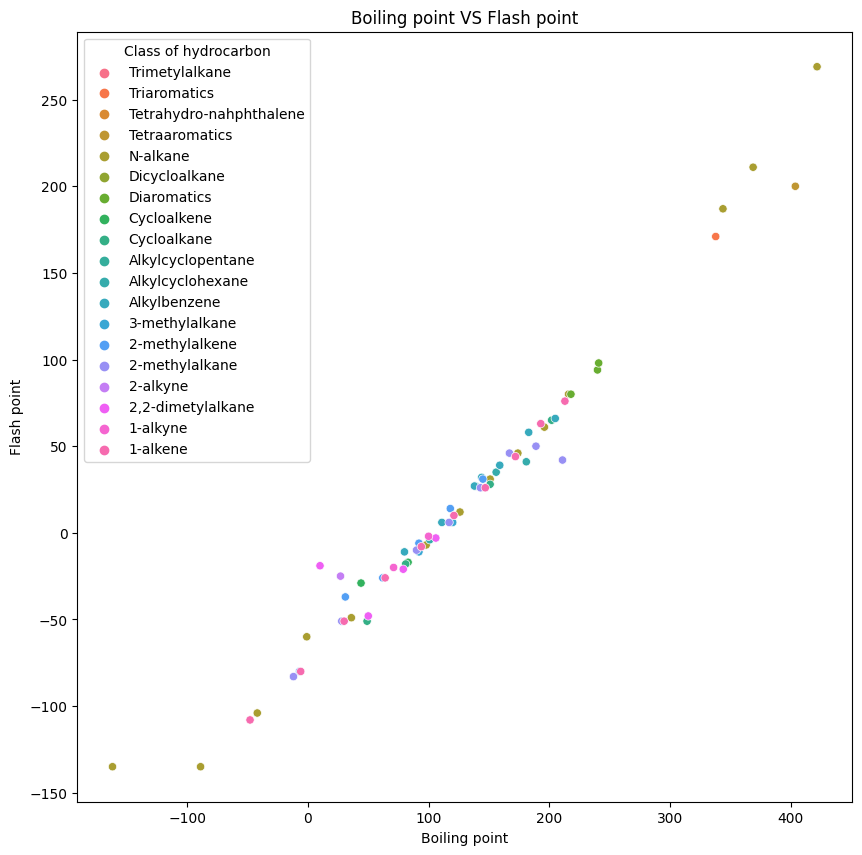

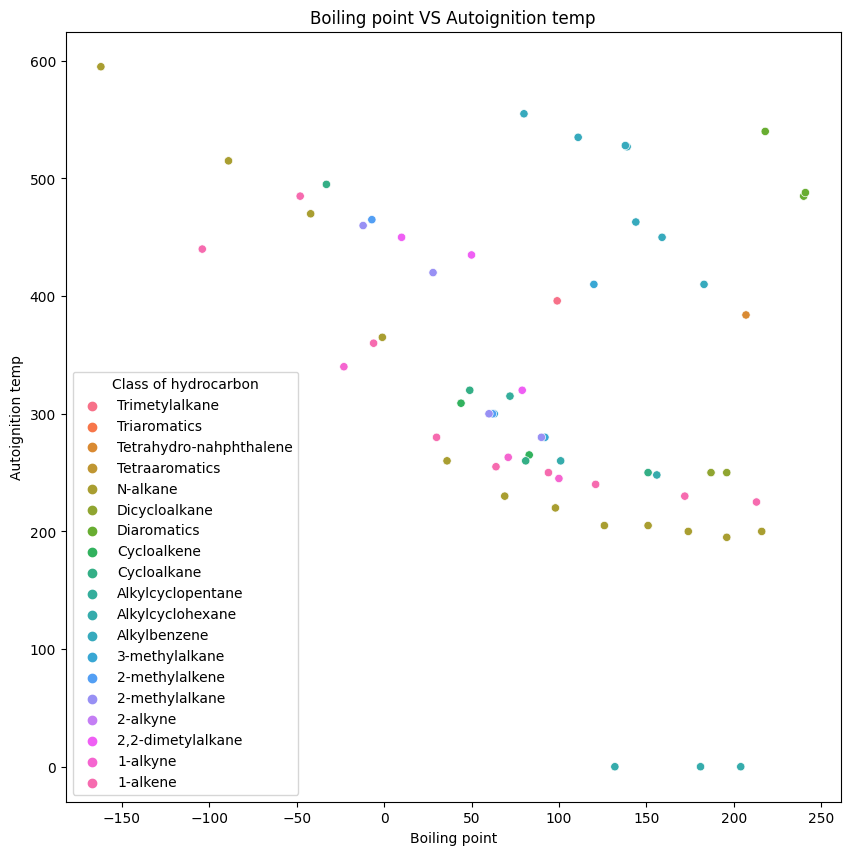

In [19]:
scatter(continuous, df, 'Class of hydrocarbon')

### ***Multivariate Analysis***

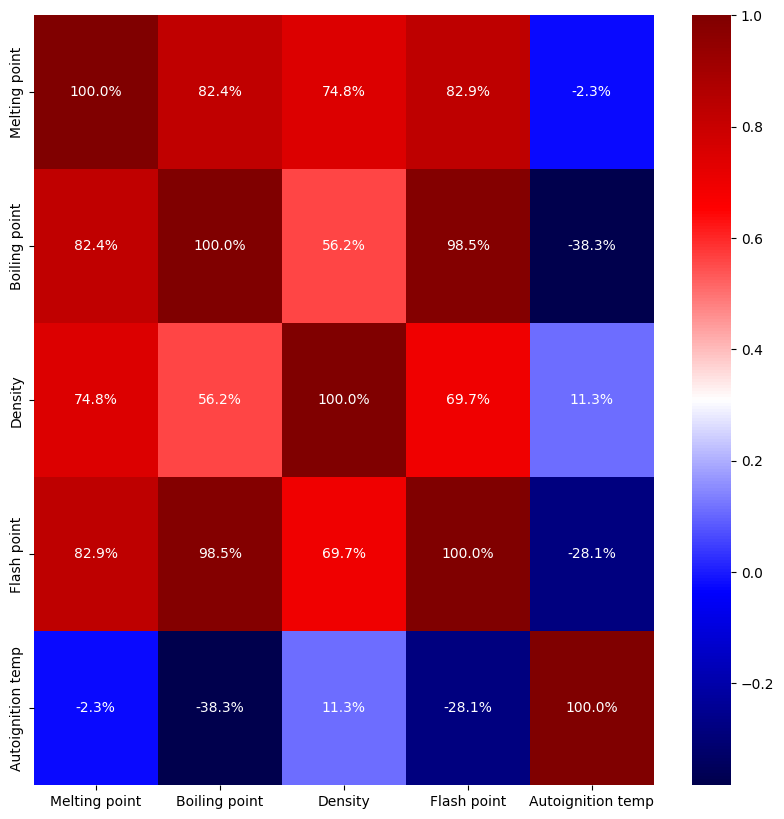

In [20]:
plt.figure(figsize=(10, 10))     # size of the figure
sns.heatmap(data=df[continuous].corr(), annot=True, cbar=True, fmt='.1%', cmap='seismic')   # heatmap to plot the correlation features to each other
plt.show()

***
# ***Data Preprocessing***
***

## ***Feature Engineering***

In [21]:
# creating a function to calculate some molecular information

def molecular_info(smiles):
    rdkit_mol = Chem.MolFromSmiles(smiles)    # turning the smiles notation to rdkit molecules
    atomic_weight = Descriptors.MolWt(rdkit_mol)    # calculating molecular weight in g/mol
    aromatic_bond_count = sum(bond.GetIsAromatic() for bond in rdkit_mol.GetBonds())  # calculating the number of aromatic bonds

    return pd.Series({'Atomic Weight': atomic_weight, 'No of Aromatic Rings': aromatic_bond_count})

In [22]:
# creating a new dataframe to store the new results

new_df = pd.DataFrame()
new_df = df['smiles'].apply(molecular_info).join(df[['Boiling point', 'Melting point']]).dropna()

In [23]:
new_df.head()

,Atomic Weight,No of Aromatic Rings,Boiling point,Melting point
0,114.232,0.0,99.0,-107.0
1,178.234,16.0,338.0,99.0
2,178.234,16.0,341.0,216.0
3,192.261,16.0,342.0,86.0
4,192.261,16.0,340.0,209.0


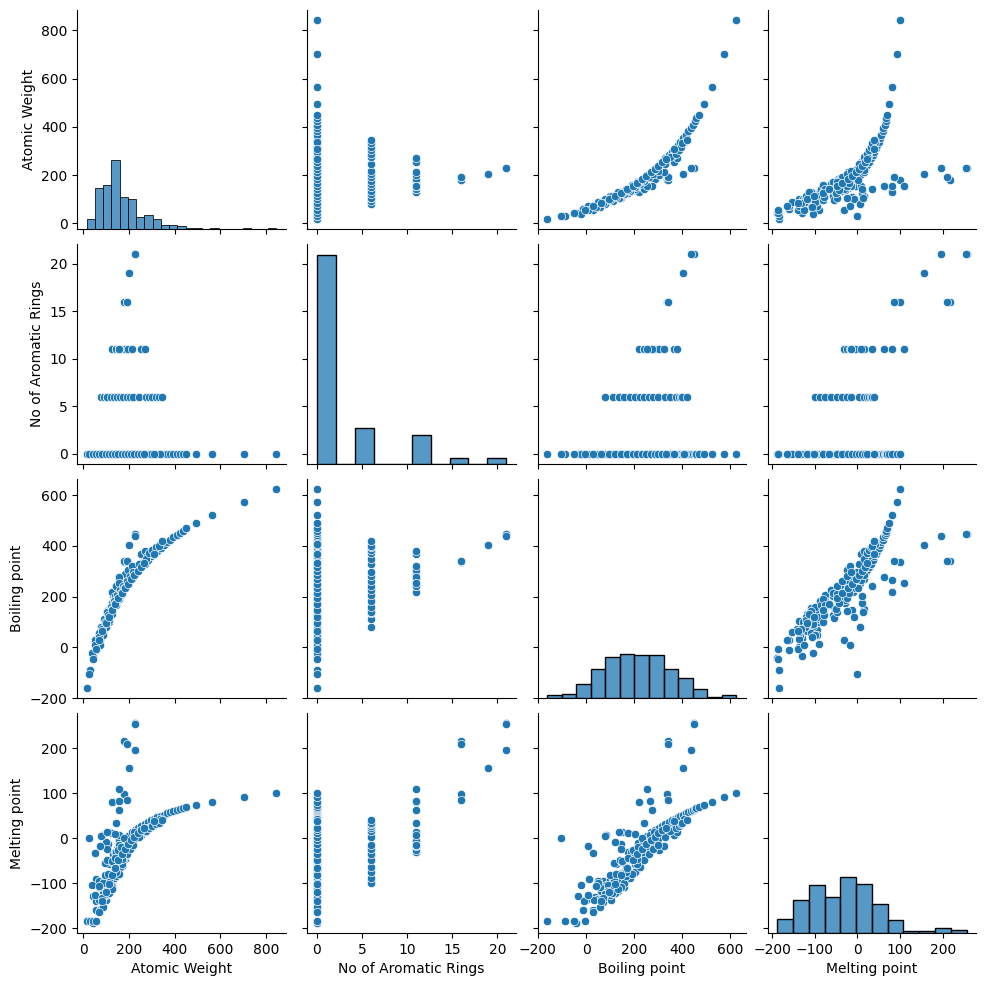

In [24]:
sns.pairplot(new_df) # a multivariate plot to visualize the new dataframe

## ***Scaling The Data***

In [25]:
X = new_df.iloc[:, :2]  #  input data
y = new_df.iloc[:, 2:]   # target

In [26]:
scaler = StandardScaler()  # an instance for scaling
x_scaled = scaler.fit_transform(X)  # scaling the input data
y_scaled = scaler.fit_transform(y)  # scaling the output data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)  # splitting the data into train and test data

***
# ***Modelling***
***

In [28]:
# creating a neural network regressor (NN) model
mlp_reg = MLPRegressor(hidden_layer_sizes=(5), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)   # training the model
mlp_pred = mlp_reg.predict(X_test)   # Make predictions on the test set
mlp_pred_df = pd.DataFrame(mlp_pred, columns=['Boiling point', 'Melting point'])  # storing the predictions in a dataframe

In [29]:
mlp_pred_df.head()

,Boiling point,Melting point
0,0.216686,0.372707
1,0.153096,-0.204279
2,-1.305714,-1.133337
3,0.959124,0.404706
4,0.821717,0.286428


## ***Model Evaluation***

In [30]:
# creating a function to evaluate the model

def model_evaluation(model, predicted_data, y_test_data):

  y_test = pd.DataFrame(y_test_data, columns=predicted_data.columns)  # converting the y_test data to a dataframe

  # looping through the predictions dataframe to evaluate each feature
  for column in predicted_data.columns:
    print(f'The performance for {column} is:\n')
    # evaluation metrics
    r_squared = r2_score(y_test[column], predicted_data[column])
    mse = mean_squared_error(y_test[column], predicted_data[column])
    mae = mean_absolute_error(y_test[column], predicted_data[column])
    rmse = np.sqrt(mse)

    print(f"R-squared: {r_squared:.4f}")
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Root Mean Sqaured Error: {rmse:.4f} \n')


    # scatterplotd of actual value vs predicted values
    plt.scatter(y_test[column], predicted_data[column])
    plt.plot([min(y_test[column]), max(y_test[column])], [min(y_test[column]), max(y_test[column])], linestyle='--', color='k')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs. Predicted for {column}")
    plt.show()
    print()

    # residual plot betwen the actual values and predicted values
    residuals = y_test[column] - predicted_data[column]
    plt.scatter(predicted_data[column], residuals)
    plt.axhline(y=0, linestyle='--', color='k')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {column}")
    plt.show()




The performance for Boiling point is:

R-squared: 0.9472
Mean Squared Error: 0.0525
Mean Absolute Error: 0.1337
Root Mean Sqaured Error: 0.2291 



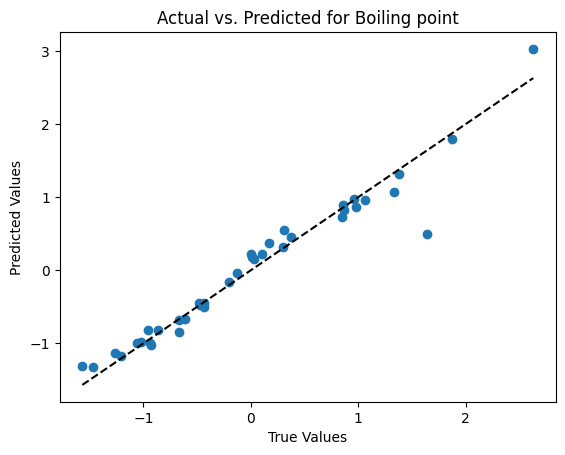

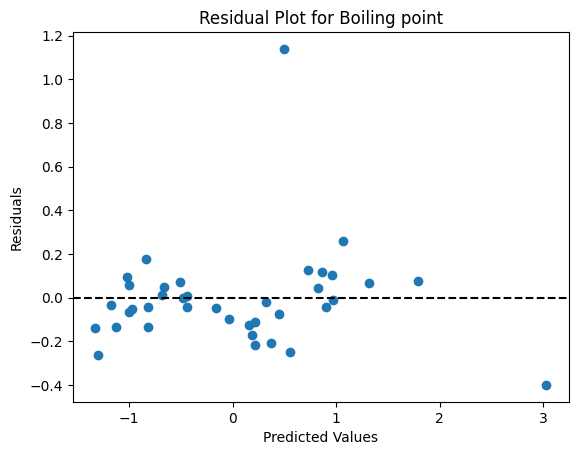

The performance for Melting point is:

R-squared: 0.7292
Mean Squared Error: 0.2535
Mean Absolute Error: 0.3966
Root Mean Sqaured Error: 0.5035 



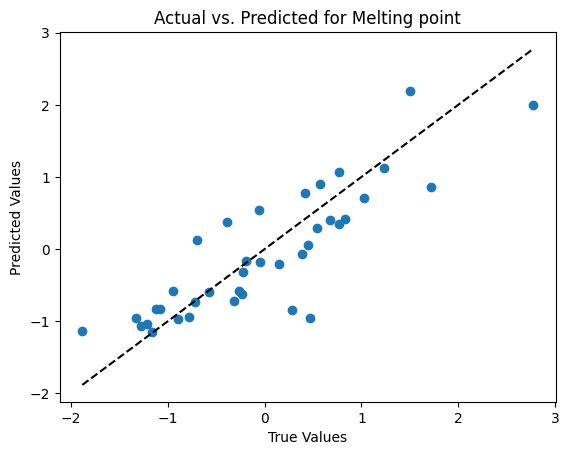

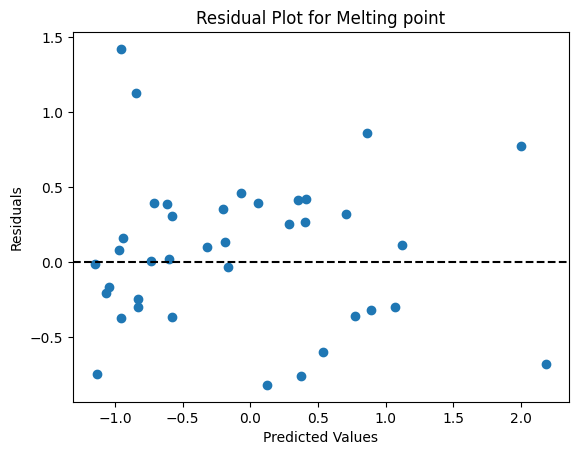

In [31]:
model_evaluation(mlp_reg, mlp_pred_df, y_test)

## ***Hyperparameter Tuning***

In [32]:
# creating a function for tuning the hyperparameters of the models
def hyperparameter_tuning(model, X_train, y_train, X_test, y_test):

    # range of hidden layer sizes to experiment with
    hidden_layer_sizes = [(5), (5, 5), (5, 5, 5), (5,10), (5,10,10), (10), (10, 5), (10, 10), (10,10,10)]

    tuned_mlp_regressor = None  # initialize the best tuned NN model
    best_train_error = np.inf   # initialize the best training error
    best_test_error = np.inf    # initialize the best testing error

    train_errors = []  # list to store training errors
    test_errors = []   # list to store testing errors

    # training models with different hidden layer sizes
    for hidden_size in hidden_layer_sizes:
        mlp_regressor = MLPRegressor(hidden_layer_sizes=hidden_size, max_iter=2000, random_state=42)
        mlp_regressor.fit(X_train, y_train)

        # predict on training and testing sets
        y_train_pred = mlp_regressor.predict(X_train)
        y_test_pred = mlp_regressor.predict(X_test)

        # calculate mean squared errors for test and train data
        train_error = mean_squared_error(y_train, y_train_pred)
        test_error = mean_squared_error(y_test, y_test_pred)

        # add to the lists
        train_errors.append(train_error)
        test_errors.append(test_error)

        # update the best model if the current model performs better
        if test_error < best_test_error:
            tuned_mlp_regressor = mlp_regressor
            best_train_error = train_error
            best_test_error = test_error

    # Plot the Model Complexity Curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(hidden_layer_sizes)), [best_train_error]*len(hidden_layer_sizes), linestyle='--', color='gray', label='Best Training Error')
    plt.plot(range(len(hidden_layer_sizes)), [best_test_error]*len(hidden_layer_sizes), linestyle='--', color='black', label='Best Testing Error')
    plt.plot(range(len(hidden_layer_sizes)), train_errors, marker='o', label='Training Error')
    plt.plot(range(len(hidden_layer_sizes)), test_errors, marker='o', label='Testing Error')
    plt.xticks(range(len(hidden_layer_sizes)), [str(size) for size in hidden_layer_sizes], rotation=45)
    plt.xlabel('Hidden Layer Sizes')
    plt.ylabel('Mean Squared Error')
    plt.title('Model Complexity Curve')
    plt.legend()
    plt.show()

    return tuned_mlp_regressor, y_test_pred

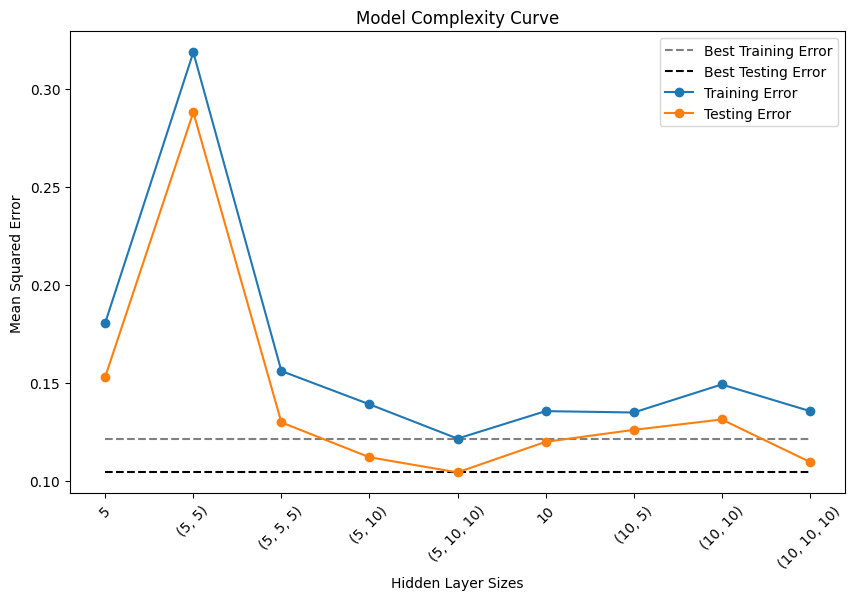

In [33]:
tuned_mlp_reg, tuned_mlp_pred = hyperparameter_tuning(mlp_reg, X_train, y_train, X_test, y_test)
# storing the predicted results to a dataframe
tuned_mlp_pred_df = pd.DataFrame(tuned_mlp_pred, columns=['Boiling point', 'Melting point'])

According the the above plot, the best architecture for the NN model is one with three hidden layers where by the first hidden layer has 5 nodes, the second has 10 nodes and the third has 10 nodes as well.

In [34]:
tuned_mlp_pred_df.head()

,Boiling point,Melting point
0,-0.085053,-0.074665
1,0.085527,-0.061392
2,-1.457529,-1.078003
3,0.840657,0.591631
4,0.759960,0.534098


### ***Evaluation of Tuned Model***

The performance for Boiling point is:

R-squared: 0.9756
Mean Squared Error: 0.0243
Mean Absolute Error: 0.1242
Root Mean Sqaured Error: 0.1559 



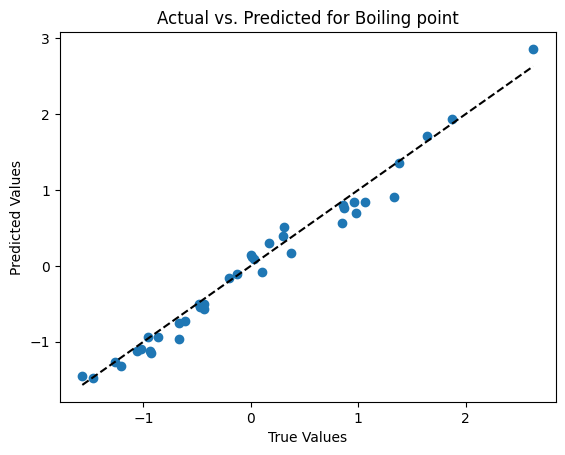

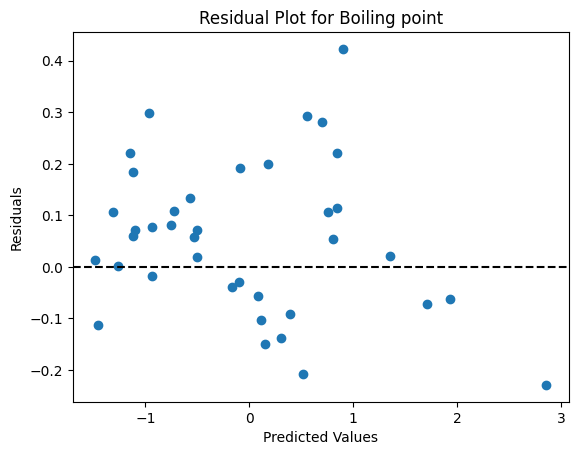

The performance for Melting point is:

R-squared: 0.7920
Mean Squared Error: 0.1947
Mean Absolute Error: 0.3163
Root Mean Sqaured Error: 0.4413 



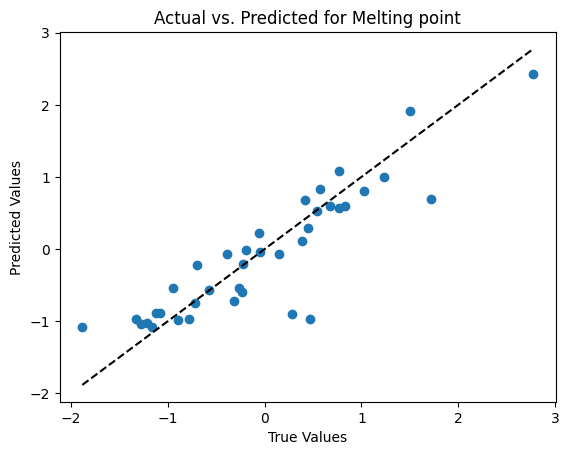

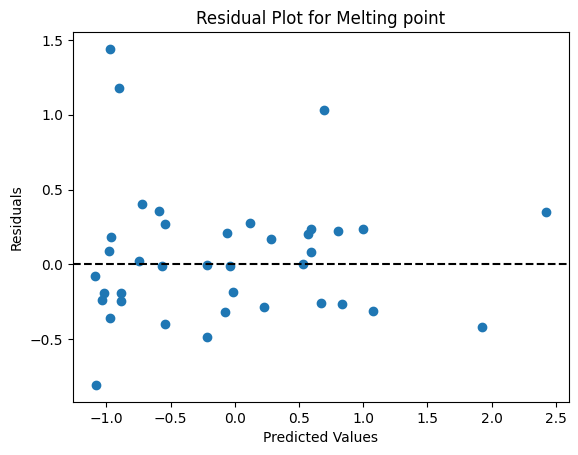

In [35]:
model_evaluation(tuned_mlp_reg, tuned_mlp_pred_df, y_test)

***
# ***Discussion***
***

For predicting boiling points and melting points of certain hydrocarbons, I used the MLPRegressor, which is a Multi-layer Perceptron Regressor, a type of artificial neural network-based regression algorithm. The objective was to use RDKit to create a new dataset containing the atomic weight and the number of aromatic rings of the hydrocarbons. Then, using the new dataset, I created a predictive regression model to estimate boiling points and melting points. I performed various steps to achieve this, including Exploratory Data Analysis, Data Preprocessing, and Modeling, with each step having substeps.

## ***Model Comparison***

### ***Before Hyperparameter Tuning***

***MLP Regressor***

Starting with the untuned MLP Regressor, I used the following evaluation metrics: R-squared (coefficient of determination), Mean Squared Error, Mean Absolute Error, and Root Mean Squared Error.

The performance for ***Boiling point*** is:

- R-squared: 0.9472
- Mean Squared Error: 0.0525
- Mean Absolute Error: 0.1337
- Root Mean Squared Error: 0.2291

The performance for ***Melting point*** is:

- R-squared: 0.7292
- Mean Squared Error: 0.2535
- Mean Absolute Error: 0.3966
- Root Mean Squared Error: 0.5035

### ***After Hyperparameter Tuning***

***Tuned MLP Regressor***

To improve the model, I evaluated a series of hidden layers. This led to the best model having an architecture of three hidden layers, where the first hidden layer has 5 nodes, the second has 10 nodes, and the third has 10 nodes as well. The performance of the tuned model is:

The performance for ***Boiling point*** is:

- R-squared: 0.9756
- Mean Squared Error: 0.0243
- Mean Absolute Error: 0.1242
- Root Mean Squared Error: 0.1559

The performance for ***Melting point*** is:

- R-squared: 0.7920
- Mean Squared Error: 0.1947
- Mean Absolute Error: 0.3163
- Root Mean Squared Error: 0.4413

In the initial model of the MLP Regressor without hyperparameter tuning, the model exhibited good performance for predicting both boiling and melting points. For boiling point prediction, the R-squared value was 94.72%, Mean Squared Error (MSE) was 5.25%, Mean Absolute Error (MAE) was 13.37%, and Root Mean Squared Error (RMSE) was 22.91%. The model's performance in predicting melting points showed an R-squared value of 72.92%, MSE of 25.35%, MAE of 39.66%, and RMSE of 50.35%. After employing hyperparameter tuning, the performance of the tuned MLP Regressor improved across all evaluation metrics. For boiling point prediction, the R-squared value increased to 97.56%, with MSE reduced to 2.43%, MAE to 12.42%, and RMSE to 15.59%. The tuned model exhibited improvements in predicting melting points, with an elevated R-squared value of 79.20%, MSE of 19.47%, MAE of 31.63%, and RMSE of 44.13%. The use of three hidden layers with specific node configurations in the tuned model showcases the substantial impact of hyperparameter optimization in refining the MLP Regressor's predictive capabilities, showcasing a percentage improvement across all metrics and emphasizing the importance of thoughtful model configuration in achieving superior performance.

***Final Remarks about the Models***

Based on the evaluation of the models, the tuned MLPRegressor outperformed the untuned MLPRegressor and Ridge Regression. It exhibited the highest R-squared value, and its predictions had the lowest average errors compared to the actual values (based on MSE, MAE, and RMSE).

### ***(Potential) Challenges and Limitations***

* Hyperparameter Tuning: Finding the right number of hidden layers and nodes using the method I did would be tedious for more complex datasets, leading to a larger list to go through, which would be computationally expensive.

* Unique IUPAC name: Each row in the dataset has a unique IUPAC name. After the machine learning modeling process, the only way to identify the compound ID is based on the predicted values of the features. This also applies to the SMILES notation.

* Data Type: Some numerical features (columns) had a data type of a string due to some values being represented in this format: '<6.7'. This makes me wonder how one deals with such values because if you convert the column to a numerical data type, those types of values turn to NaN. This causes some data to be lost and could be a significant problem if there are many of those types of values.